In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as sts

In [151]:
df=pd.read_csv("LenderData.csv")
df.head()

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7


### Using the distributions of interest rates and median income (10 points)

Create a plot of the histogram of high interest rate lenders interest rates avgrate. Use 30 bins. Make sure to label your axes and give the figure a title. If you had to group lenders into  𝑁  categories, how many categories would you choose based on the interest rate data? That is, how many groupings to you see in these data?

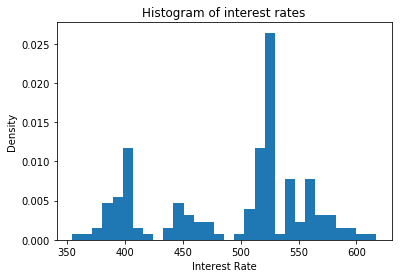

In [152]:
plt.hist(df['avgrate'],bins=30, density=True)
plt.xlabel("Interest Rate")
plt.ylabel("Density")
plt.title("Histogram of interest rates")
plt.show()

Four groups: 1. 350-475; 2. 476-490; 3. 491-540; 4. 541-650

Create a plot of the histogram of median total household income medtotinc2010. Use 30 bins. Make sure to label your axes and give the figure a title.

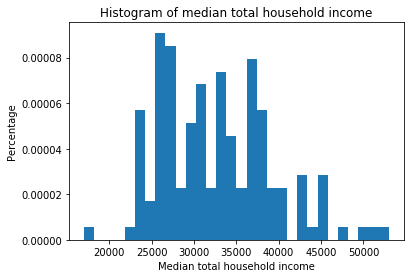

In [153]:
plt.hist(df['medtotinc2010'],bins=30, density=True)
plt.xlabel("Median total household income")
plt.ylabel("Percentage")
plt.title("Histogram of median total household income")
plt.show()

In [154]:
df['medtotinc2010'].describe()

count      147.000000
mean     32772.135390
std       6639.982466
min      17068.277340
25%      27502.000000
50%      31611.000000
75%      36955.138670
max      52972.890630
Name: medtotinc2010, dtype: float64

Use MLE to fit a lognormal distribution  𝐿𝑁(𝜇,𝜎)  to the median income data medtotinc2010. Report your estimated  𝜇̂ 𝑚𝑙𝑒  and  𝜎̂ 𝑚𝑙𝑒  as well as the likelihood function value at the maximum (not the negative log likelihood). Report your estimate of the variance-covariance matrix of your maximum likelihood estimates of  𝜇̂ 𝑚𝑙𝑒 and  𝜎̂ 𝑚𝑙𝑒 . Report the standard error on the estimate for  𝜇̂ 𝑚𝑙𝑒 .

### Lognormal

In [155]:
# Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [156]:
# Define log likelihood function for the log normal distribution
def log_lik_trunclognorm(xvals, mu, sigma, cut_lb, cut_ub):

    pdf_vals = trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [157]:
# Compute the negative of the log likelihood function given parameters and data
def crit(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_trunclognorm(xvals, mu, abs(sigma), cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [158]:
mu_init = 10
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
mle_args = (df['medtotinc2010'], "None","None")
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE= results_uncstr.x[0]
sig_MLE = results_uncstr.x[1]
print('ML estimates for µ=', mu_MLE)
print('ML estimates for σ', sig_MLE)
print("Maximized Log Likelihood:",-results_uncstr.fun)
#log_lik_trunclognorm(df['medtotinc2010'],mu_MLE, sig_MLE, "None","None")

ML estimates for µ= 10.377380200505925
ML estimates for σ 0.1994992969157321
Maximized Log Likelihood: -1497.1030088862083


Maximized Likelihood is:
$e^{MLL}=e^{-1497}$

In [159]:
#Twp ways to get Maximized Likelihood (very close to 0)
np.prod(trunc_lognorm_pdf(df['medtotinc2010'], mu_MLE, sig_MLE, "None","None"))

np.exp(-results_uncstr.fun)

0.0

In [160]:
vcv_mle = results_uncstr.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE):')
print(vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE):
[[ 2.54949555e-08 -1.13104761e-08]
 [-1.13104761e-08  1.89902896e-04]]
Standard error for mu estimate =  0.00015967139844098166
Standard error for sigma estimate =  0.013780525987273513


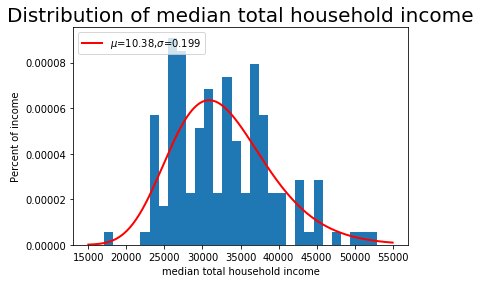

In [161]:
# Plot the histogram of the data
dist_pts = np.linspace(15000, 55000, 300)
plt.hist(df['medtotinc2010'], 30, density=True)

## Plot the MLE estimated distribution
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_MLE,sig_MLE,"None","None"),
         linewidth=2, color='r', label='$\mu$=10.38,$\sigma$=0.199')
plt.legend(loc='upper left')

plt.title('Distribution of median total household income', fontsize=20)
plt.xlabel('median total household income')
plt.ylabel('Percent of income')
plt.show()

### Normal

In [162]:
# Define function that generates values of a normal pdf
def trunc_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [163]:
# Define log likelihood function for the normal distribution
def log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub):

    pdf_vals = trunc_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [164]:
# Compute the negative of the log likelihood function given parameters and data
def crit(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [170]:
mu_init = 33000
sig_init = 5000
params_init = np.array([mu_init, sig_init])
mle_args = (df['medtotinc2010'], "None","None")
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE= results_uncstr.x[0]
sig_MLE = results_uncstr.x[1]
print('ML estimates for µ=', mu_MLE)
print('ML estimates for σ', sig_MLE)
print("Maximized Log Likelihood:",-results_uncstr.fun)
#log_lik_trunclognorm(df['medtotinc2010'],mu_MLE, sig_MLE, "None","None")

ML estimates for µ= 32901.683156212486
ML estimates for σ 6622.168530667489
Maximized Log Likelihood: -1501.837558492315


In [166]:
vcv_mle = results_uncstr.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE):')
print(vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE):
[[329216.80769939  18029.71588382]
 [ 18029.71588382 130717.15512698]]
Standard error for mu estimate =  573.7741783135466
Standard error for sigma estimate =  361.54827496059534


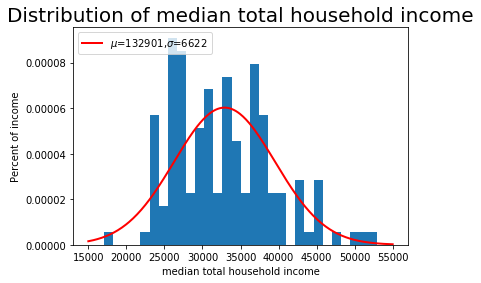

In [171]:
# Plot the histogram of the data
dist_pts = np.linspace(15000, 55000, 300)
plt.hist(df['medtotinc2010'], 30, density=True)

## Plot the MLE estimated distribution
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_MLE,sig_MLE,"None","None"),
         linewidth=2, color='r', label='$\mu$=132901,$\sigma$=6622')
plt.legend(loc='upper left')

plt.title('Distribution of median total household income', fontsize=20)
plt.xlabel('median total household income')
plt.ylabel('Percent of income')
plt.show()